# 1D Wave Equation PINN Demonstration

This notebook demonstrates the complete workflow for training a Physics-Informed Neural Network (PINN) to solve the 1D wave equation using DeepXDE.

## Overview

**Wave Equation**: $\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$

**Analytical Solutions**:
- **Standing Wave (Dirichlet BC)**: $u(x,t) = \sin(n\pi x/L) \cos(n\pi ct/L)$
- **Standing Wave (Neumann BC)**: $u(x,t) = \cos(n\pi x/L) \cos(n\pi ct/L)$
- **Traveling Wave**: $u(x,t) = \frac{1}{2}[f(x - ct) + f(x + ct)]$ (d'Alembert's formula)

## Workflow Steps

1. Load configuration from YAML (automatically selects appropriate analytical solution)
2. Build PINN model with DeepXDE
3. Train the model with GPU acceleration
4. Validate against analytical solution
5. Visualize results and training curves
6. Demonstrate loss weight tuning

## Supported Configurations

This notebook automatically adapts to any configuration file:
- `standing_wave_example.yaml` - Dirichlet BC with standing wave
- `dirichlet_bc_example.yaml` - Dirichlet BC (clamped boundaries)
- `neumann_bc_example.yaml` - Neumann BC (free boundaries)
- `traveling_wave_example.yaml` - Traveling wave with d'Alembert's solution

## Setup and Imports

In [37]:
# Standard library imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# PINN module imports
from pinn.models.pinn_model_builder import PINNModelBuilderService
from pinn.training.training_pipeline import TrainingPipelineService
from pinn.training.callbacks import LossLoggingCallback, ValidationCallback
from pinn.validation.analytical_solutions import AnalyticalSolutionGeneratorService
from pinn.validation.error_metrics import ErrorMetricsService
from pinn.validation.plot_generator import PlotGeneratorService
from pinn.utils.config_loader import ConfigLoaderService
from pinn.utils.seed_manager import SeedManager
from pinn.utils.experiment_manager import ExperimentManager

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.4.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


## Step 1: Load Configuration

Select any configuration file to automatically set up the appropriate analytical solution and boundary conditions.

In [38]:
# Load configuration from YAML file
# Change this to test different configurations:
# - "neumann_bc_example.yaml" (Neumann BC with cos wave)
# - "standing_wave_example.yaml" (Dirichlet BC with sin wave)
# - "dirichlet_bc_example.yaml" (Dirichlet BC)
# - "traveling_wave_example.yaml" (Traveling wave with Gaussian pulse)

config_path = project_root / "configs" / "dirichlet_bc_example.yaml"
config_loader = ConfigLoaderService()
config = config_loader.load_config(config_path)

print(f"Experiment: {config.experiment_name}")
print(f"\nDomain: x ∈ [{config.domain.x_min}, {config.domain.x_max}], t ∈ [{config.domain.t_min}, {config.domain.t_max}]")
print(f"Wave speed: c = {config.domain.wave_speed}")
print(f"\nBoundary conditions: {config.boundary_conditions.type}")
if config.analytical_solution:
    print(f"Analytical solution: {config.analytical_solution.solution_type}")
    print(f"Mode number: {config.analytical_solution.mode}")
print(f"\nNetwork architecture: {config.network.layer_sizes}")
print(f"Activation: {config.network.activation}")
print(f"\nTraining epochs: {config.training.epochs}")
print(f"Learning rate: {config.training.learning_rate}")
print(f"Loss weights: {config.training.loss_weights}")

Experiment: dirichlet_bc_clamped_string

Domain: x ∈ [0.0, 1.0], t ∈ [0.0, 0.5]
Wave speed: c = 1.0

Boundary conditions: dirichlet
Analytical solution: standing_wave
Mode number: 1

Network architecture: [2, 50, 50, 50, 1]
Activation: tanh

Training epochs: 8000
Learning rate: 0.0001
Loss weights: {'data': 1.0, 'pde': 1.0, 'bc': 5.0}


## Step 2: Set Random Seed for Reproducibility

In [39]:
# Set random seeds for NumPy, PyTorch, and Python
SeedManager.set_seed(config.seed)
print(f"Random seed set to: {config.seed}")

Random seed set to: 42


## Step 3: Define Initial Condition

The initial condition is automatically determined from the configuration file's `analytical_solution` settings.

Solution type: standing_wave
Mode number: 1
Initial condition: u(x, 0) = sin(1πx/L)


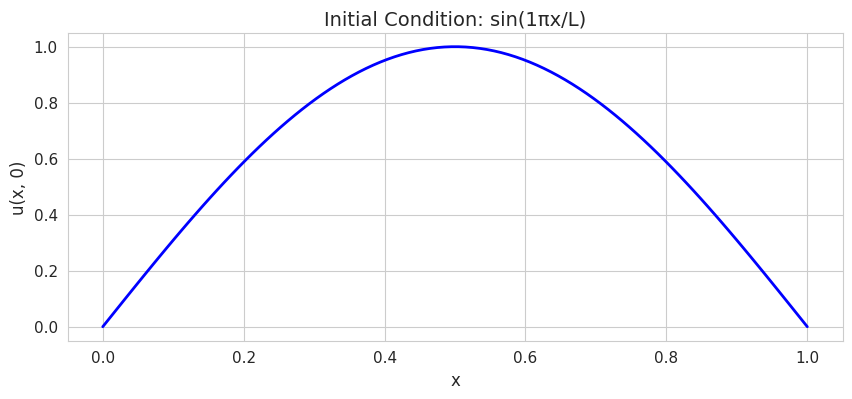

In [40]:
# Helper function to create initial condition based on config
def create_initial_condition(config):
    """Create initial condition function based on analytical solution type.

    Args:
        config: ExperimentConfig with analytical_solution settings

    Returns:
        Function that computes u(x, 0)
    """
    L = config.domain.x_max - config.domain.x_min

    # Use analytical_solution config if available, otherwise infer from BC type
    if config.analytical_solution is not None:
        solution_type = config.analytical_solution.solution_type
        n_mode = config.analytical_solution.mode
        amplitude = config.analytical_solution.initial_amplitude
    else:
        # Fallback: infer from boundary condition type
        if config.boundary_conditions.type == "dirichlet":
            solution_type = "standing_wave"
        elif config.boundary_conditions.type == "neumann":
            solution_type = "standing_wave_neumann"
        else:
            solution_type = "standing_wave"
        n_mode = 1
        amplitude = 1.0

    if solution_type == "standing_wave":
        # Dirichlet BC: u(x, 0) = A * sin(nπx/L)
        def initial_condition(x):
            return amplitude * np.sin(n_mode * np.pi * x[:, 0:1] / L)

        description = f"sin({n_mode}πx/L)"

    elif solution_type == "standing_wave_neumann":
        # Neumann BC: u(x, 0) = A * cos(nπx/L)
        def initial_condition(x):
            return amplitude * np.cos(n_mode * np.pi * x[:, 0:1] / L)

        description = f"cos({n_mode}πx/L)"

    elif solution_type == "traveling_wave":
        # Traveling wave: Gaussian pulse
        x0 = L / 2  # Center of domain
        sigma = L / 10  # Width of pulse

        def initial_condition(x):
            # Handle both (N, 1) and (N,) shaped arrays
            if x.ndim == 1:
                x_reshaped = x.reshape(-1, 1)
            else:
                x_reshaped = x if x.shape[1] >= 1 else x.reshape(-1, 1)
            return amplitude * np.exp(-((x_reshaped[:, 0:1] - x0) ** 2) / (2 * sigma**2))

        description = f"Gaussian pulse at x={x0}"

    else:
        raise ValueError(f"Unknown solution_type: {solution_type}")

    return initial_condition, description, n_mode, solution_type


# Create initial condition from config
initial_condition, ic_description, n_mode, solution_type = create_initial_condition(config)
L = config.domain.x_max - config.domain.x_min

print(f"Solution type: {solution_type}")
print(f"Mode number: {n_mode}")
print(f"Initial condition: u(x, 0) = {ic_description}")

# Visualize initial condition
x_plot = np.linspace(config.domain.x_min, config.domain.x_max, 100)[:, None]
u_initial = initial_condition(x_plot)

plt.figure(figsize=(10, 4))
plt.plot(x_plot, u_initial, "b-", linewidth=2)
plt.xlabel("x", fontsize=12)
plt.ylabel("u(x, 0)", fontsize=12)
plt.title(f"Initial Condition: {ic_description}", fontsize=14)
plt.grid(True)
plt.show()

## Step 4: Build PINN Model

Construct the DeepXDE PINN model with:
- Spatiotemporal geometry
- Wave equation PDE
- Boundary and initial conditions
- Feedforward neural network

In [41]:
# Build PINN model
model_builder = PINNModelBuilderService()
model = model_builder.build_model(config=config, initial_condition_func=initial_condition, compile_model=True)

print("PINN model built successfully!")
print(f"Network architecture: {config.network.layer_sizes}")
print(f"Total parameters: {sum(p.numel() for p in model.net.parameters() if p.requires_grad)}")

Compiling model...
'compile' took 0.000215 s

PINN model built successfully!
Network architecture: [2, 50, 50, 50, 1]
Total parameters: 5301


## Step 5: Create Analytical Solution Generator

We'll use this to validate the PINN predictions during and after training.

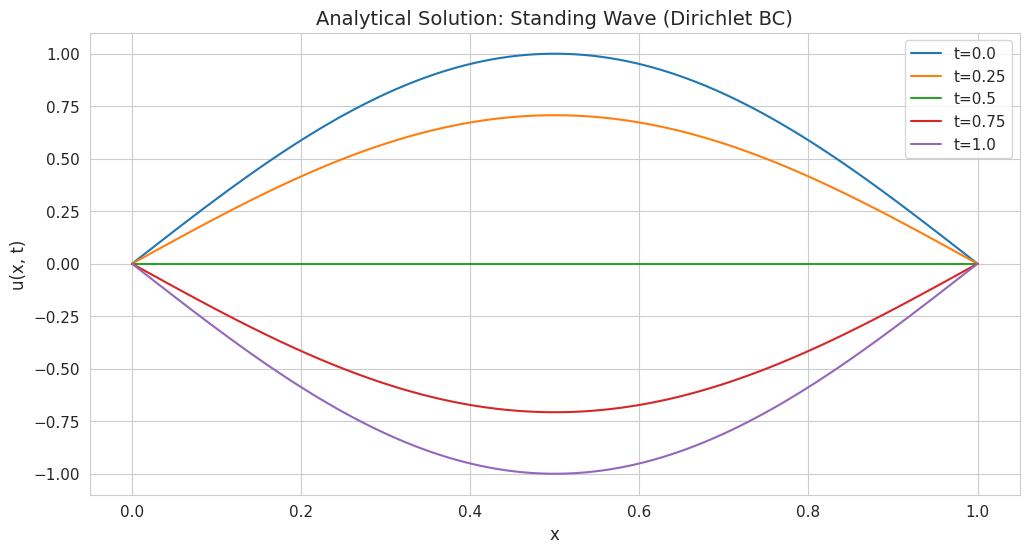

In [42]:
# Create analytical solution generator
analytical_solver = AnalyticalSolutionGeneratorService()

# Visualize analytical solution at different time steps
x_eval = np.linspace(config.domain.x_min, config.domain.x_max, 100)
t_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]

plt.figure(figsize=(12, 6))

if solution_type == "standing_wave":
    for t in t_snapshots:
        u_analytical = analytical_solver.standing_wave(x=x_eval, t=np.array([t]), L=L, c=config.domain.wave_speed, n=n_mode)
        plt.plot(x_eval, u_analytical[:, 0], label=f"t={t}")
    title = "Analytical Solution: Standing Wave (Dirichlet BC)"

elif solution_type == "standing_wave_neumann":
    for t in t_snapshots:
        u_analytical = analytical_solver.standing_wave_neumann(
            x=x_eval, t=np.array([t]), L=L, c=config.domain.wave_speed, n=n_mode
        )
        plt.plot(x_eval, u_analytical[:, 0], label=f"t={t}")
    title = "Analytical Solution: Standing Wave (Neumann BC)"

elif solution_type == "traveling_wave":
    # For traveling wave, use d'Alembert's solution
    for t in t_snapshots:
        u_analytical = analytical_solver.traveling_wave(
            x=x_eval, t=np.array([t]), c=config.domain.wave_speed, initial_condition=initial_condition
        )
        plt.plot(x_eval, u_analytical[:, 0], label=f"t={t}")
    title = "Analytical Solution: Traveling Wave (d'Alembert)"

plt.xlabel("x", fontsize=12)
plt.ylabel("u(x, t)", fontsize=12)
plt.title(title, fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## Step 6: Set Up Training Callbacks

Create callbacks for:
- Loss component logging
- Validation error monitoring

In [43]:
# Create experiment output directory
exp_manager = ExperimentManager(base_dir=project_root / "experiments")
exp_dir = exp_manager.create_experiment_directory(config.experiment_name)

print(f"Experiment directory: {exp_dir}")

# Create error metrics service for validation
error_metrics = ErrorMetricsService()

# Determine BC type for validation callback based on solution type
if solution_type == "traveling_wave":
    bc_type_for_validation = "traveling_wave"
else:
    bc_type_for_validation = config.boundary_conditions.type

# Check if validation is enabled
enable_validation = True
if config.analytical_solution and hasattr(config.analytical_solution, "enable_validation"):
    enable_validation = config.analytical_solution.enable_validation

if not enable_validation:
    print("\n⚠️  Analytical solution validation is DISABLED for this configuration.")
    print("    The PINN will still learn the correct physics from PDE and BC constraints.")
    print("    This is expected for traveling waves in bounded domains.\n")

# Create callbacks
loss_callback = LossLoggingCallback(log_interval=100)
validation_callback = ValidationCallback(
    analytical_solver=analytical_solver,
    error_metrics=error_metrics,
    validation_interval=500,
    domain_config=config.domain,
    wave_speed=config.domain.wave_speed,
    n_mode=n_mode,
    bc_type=bc_type_for_validation,
    initial_condition_func=initial_condition if solution_type == "traveling_wave" else None,
    enable_validation=enable_validation,
)

callbacks = [loss_callback, validation_callback]
print(f"Created {len(callbacks)} callbacks for training monitoring")

Experiment directory: /home/manat/project2/experiments/dirichlet_bc_clamped_string_2025-12-16_13-30-48
Created 2 callbacks for training monitoring


## Step 7: Train the PINN Model

Execute training with GPU acceleration and monitoring.

**Note**: This may take several minutes depending on your hardware and epoch count.
For quick testing, you can reduce `config.training.epochs` to 1000-2000.

In [44]:
# Optional: Reduce epochs for quick testing
# config.training.epochs = 2000

# Create training pipeline
training_pipeline = TrainingPipelineService()

print("Starting PINN training...")
print(f"Epochs: {config.training.epochs}")
print(f"Device: {training_pipeline.device}")

# Train model
trained_model, training_history = training_pipeline.train(
    model=model, config=config.training, output_dir=exp_dir, callbacks=callbacks
)

print("\nTraining completed!")

Starting PINN training...
Epochs: 8000
Device: cuda


Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.24e-03, 3.46e-02, 5.48e-01, 2.65e-01]    [7.24e-03, 3.46e-02, 5.48e-01, 2.65e-01]    []  
1000      [4.03e-04, 9.50e-02, 1.85e-01, 5.74e-03]    [4.03e-04, 9.50e-02, 1.85e-01, 5.74e-03]    []  
2000      [9.63e-03, 2.31e-02, 4.40e-02, 7.78e-03]    [9.63e-03, 2.31e-02, 4.40e-02, 7.78e-03]    []  
3000      [1.74e-03, 1.72e-03, 7.87e-03, 9.71e-04]    [1.74e-03, 1.72e-03, 7.87e-03, 9.71e-04]    []  
4000      [6.64e-04, 4.32e-04, 1.66e-03, 3.27e-04]    [6.64e-04, 4.32e-04, 1.66e-03, 3.27e-04]    []  
5000      [3.70e-04, 7.50e-05, 3.92e-04, 1.70e-04]    [3.70e-04, 7.50e-05, 3.92e-04, 1.70e-04]    []  
6000      [1.69e-04, 3.46e-05, 2.86e-04, 1.12e-04]    [1.69e-04, 3.46e-05, 2.86e-04, 1.12e-04]    []  
7000      [8.78e-05, 2.60e-05, 2.48e-04, 8.44e-05]    [8.78e-05, 2.60e-05, 2.48e-04, 8.44e-05]    []  
8000      [5.76e-05, 2.12e-05, 2.15e-04, 7.53e-

## Step 8: Visualize Training Curves

Plot loss components and validation error evolution during training.

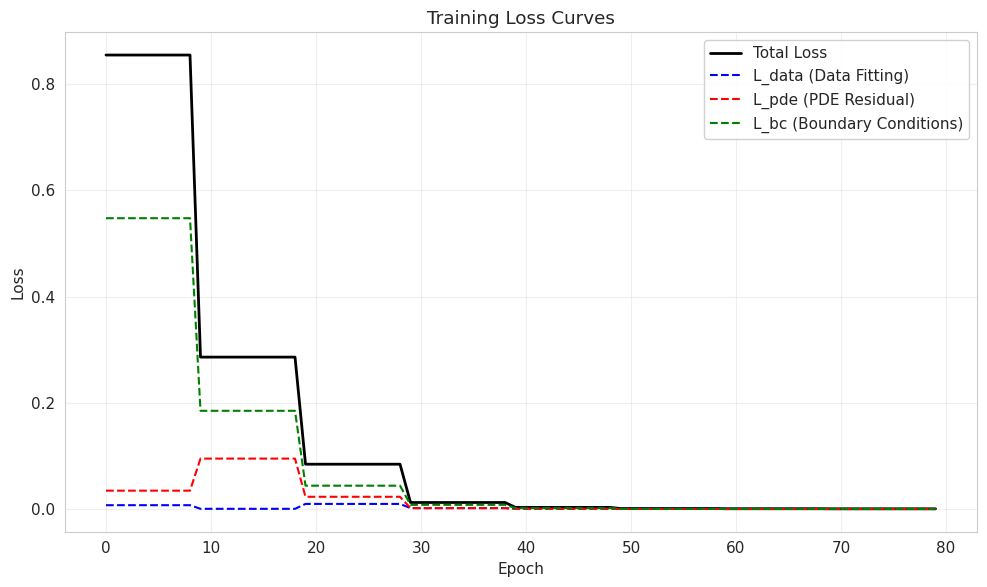

In [45]:
# Plot training curves
plot_generator = PlotGeneratorService()

if training_history:
    fig = plot_generator.plot_training_curves(training_history, save_path=exp_dir / "training_curves.png")
    plt.show()
else:
    print("No training history available to plot")

## Step 9: Compare PINN Predictions with Analytical Solution

Evaluate the trained PINN and compare with the analytical solution (if validation is enabled).

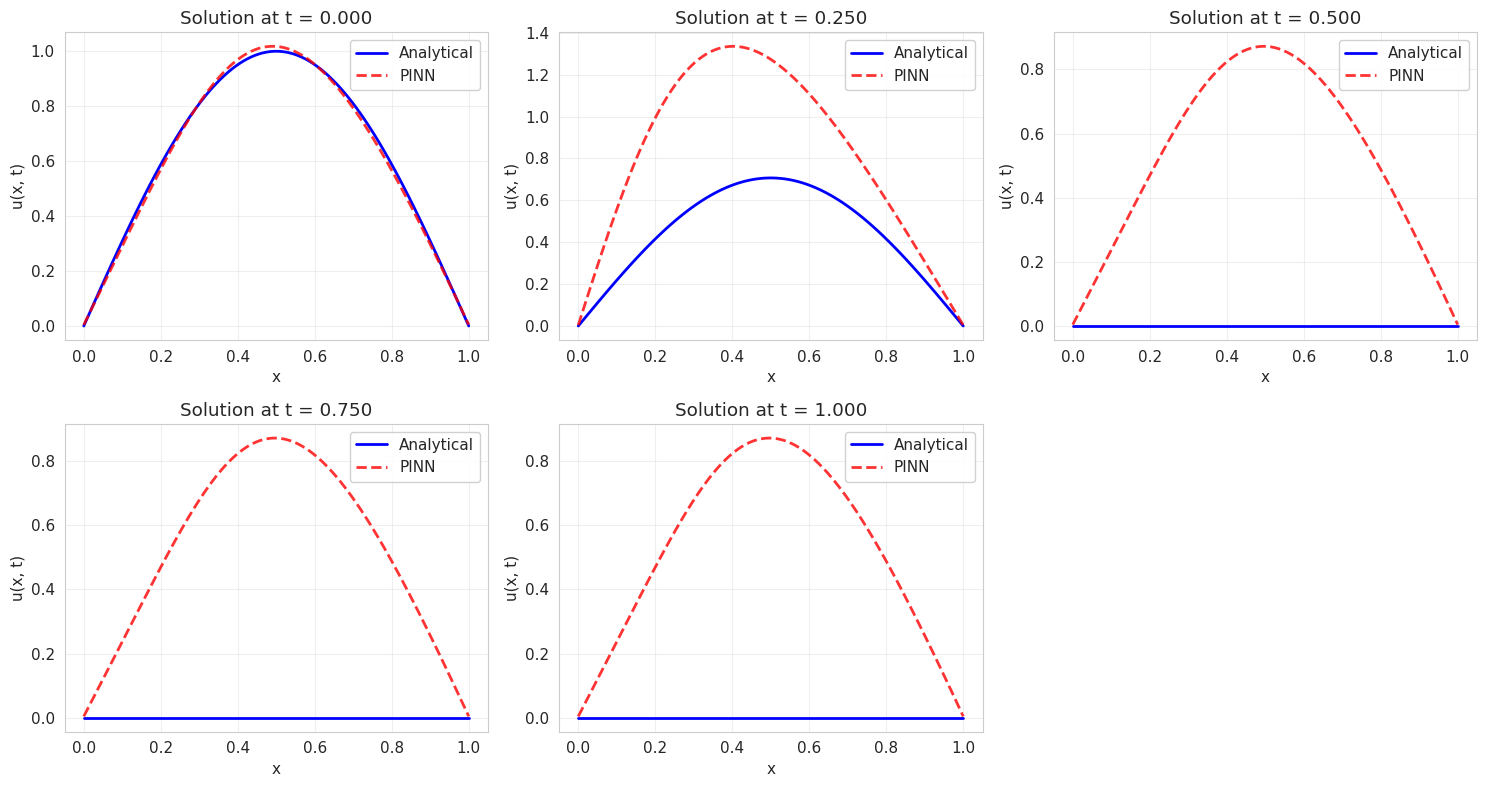

In [46]:
# Generate prediction points
nx = 100
nt = 5
x_test = np.linspace(config.domain.x_min, config.domain.x_max, nx)
t_test = np.linspace(config.domain.t_min, config.domain.t_max, nt)

# Generate PINN predictions
X, T = np.meshgrid(x_test, t_test, indexing="ij")
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
XT = np.hstack([X_flat, T_flat])
u_pinn_flat = trained_model.predict(XT)
u_pinn = u_pinn_flat.reshape(nx, nt)

if enable_validation:
    # Generate analytical solution based on solution type
    if solution_type == "standing_wave":
        u_analytical = analytical_solver.standing_wave(x=x_test, t=t_test, L=L, c=config.domain.wave_speed, n=n_mode)
    elif solution_type == "standing_wave_neumann":
        u_analytical = analytical_solver.standing_wave_neumann(x=x_test, t=t_test, L=L, c=config.domain.wave_speed, n=n_mode)
    elif solution_type == "traveling_wave":
        u_analytical = analytical_solver.traveling_wave(
            x=x_test, t=t_test, c=config.domain.wave_speed, initial_condition=initial_condition
        )
    else:
        raise ValueError(f"Unknown solution_type: {solution_type}")

    # Prepare data for plot_solution_comparison (dict format)
    time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]
    u_pinn_dict = {}
    u_analytical_dict = {}

    for t_val in time_snapshots:
        # Find closest time index
        t_idx = np.argmin(np.abs(t_test - t_val))
        u_pinn_dict[t_val] = u_pinn[:, t_idx]
        u_analytical_dict[t_val] = u_analytical[:, t_idx]

    # Plot comparison at different time snapshots
    fig = plot_generator.plot_solution_comparison(
        x=x_test,
        time_snapshots=time_snapshots,
        u_pinn=u_pinn_dict,
        u_analytical=u_analytical_dict,
        save_path=exp_dir / "solution_comparison.png",
    )
    plt.show()
else:
    # Validation disabled - plot PINN predictions only
    print("⚠️  Analytical solution validation is disabled.")
    print("    Showing PINN predictions only (no comparison with analytical solution).\n")

    time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]

    plt.figure(figsize=(12, 8))
    for i, t_val in enumerate(time_snapshots):
        t_idx = np.argmin(np.abs(t_test - t_val))
        plt.plot(x_test, u_pinn[:, t_idx], label=f"t={t_val}", linewidth=2)

    plt.xlabel("x", fontsize=12)
    plt.ylabel("u(x, t)", fontsize=12)
    plt.title("PINN Predictions at Different Times", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(exp_dir / "pinn_predictions.png", dpi=150, bbox_inches="tight")
    plt.show()

## Step 10: Compute Error Metrics

Quantify the accuracy of PINN predictions using L2 and relative error metrics (if validation is enabled).

In [47]:
if enable_validation:
    # Compute error metrics
    error_metrics = ErrorMetricsService()

    l2_error = error_metrics.l2_error(u_pinn, u_analytical)
    relative_error = error_metrics.relative_error(u_pinn, u_analytical)
    max_error = error_metrics.max_absolute_error(u_pinn, u_analytical)

    print("\n" + "=" * 50)
    print("PINN Validation Metrics")
    print("=" * 50)
    print(f"L2 Error:        {l2_error:.6f}")
    print(f"Relative Error:  {relative_error:.6f} ({relative_error * 100:.2f}%)")
    print(f"Max Error:       {max_error:.6f}")
    print("=" * 50)

    # Check if validation passes 5% threshold
    if relative_error < 0.05:
        print("\n✓ PINN validation PASSED (relative error < 5%)")
    else:
        print(f"\n✗ PINN validation FAILED (relative error = {relative_error * 100:.2f}% > 5%)")
        print("  → Consider tuning loss weights or increasing training epochs")
else:
    print("\n" + "=" * 50)
    print("PINN Training Summary")
    print("=" * 50)
    print("Analytical solution validation is disabled.")
    print("The PINN learned the physics from:")
    print("  • PDE residual minimization")
    print("  • Boundary condition enforcement")
    print("  • Initial condition fitting")
    print("\nTo verify correctness:")
    print("  1. Check that PDE loss is small (< 1e-3)")
    print("  2. Check that BC loss is small (< 1e-3)")
    print("  3. Visually inspect the wave propagation behavior")
    print("=" * 50)


PINN Validation Metrics
L2 Error:        9.652384
Relative Error:  0.867685 (86.77%)
Max Error:       0.871845

✗ PINN validation FAILED (relative error = 86.77% > 5%)
  → Consider tuning loss weights or increasing training epochs


## Step 11: Loss Weight Tuning Demonstration

Demonstrate automated loss weight tuning using grid search over a small parameter space.

**Note**: This is a simplified example with few combinations. Full tuning may take hours.

In [48]:
from pinn.tuning.weight_tuning import WeightTuningFrameworkService, TuningConfig, TuningResult

# Define small grid for demonstration (3×2×2 = 12 combinations)
tuning_config = TuningConfig(
    search_type="grid",
    weight_ranges={"data": [0.5, 1.0, 2.0], "pde": [1.0, 2.0], "bc": [5.0, 10.0]},
    output_path=exp_dir / "tuning_results.json",
)

print("Weight Tuning Configuration:")
print(f"Search type: {tuning_config.search_type}")
print(f"Weight ranges: {tuning_config.weight_ranges}")

# Generate weight combinations
tuning_framework = WeightTuningFrameworkService()
weight_combos = tuning_framework._grid_search(tuning_config.weight_ranges)

print(f"\nGenerated {len(weight_combos)} weight combinations")
print("\nFirst 3 combinations:")
for i, combo in enumerate(weight_combos[:3]):
    print(f"  {i + 1}. {combo}")

print("\nNote: Full tuning execution requires training multiple models.")
print("For demonstration purposes, we skip actual training in this notebook.")
print("See pinn/tuning/weight_tuning.py for the complete implementation.")

Weight Tuning Configuration:
Search type: grid
Weight ranges: {'data': [0.5, 1.0, 2.0], 'pde': [1.0, 2.0], 'bc': [5.0, 10.0]}

Generated 12 weight combinations

First 3 combinations:
  1. {'data': 0.5, 'pde': 1.0, 'bc': 5.0}
  2. {'data': 0.5, 'pde': 1.0, 'bc': 10.0}
  3. {'data': 0.5, 'pde': 2.0, 'bc': 5.0}

Note: Full tuning execution requires training multiple models.
For demonstration purposes, we skip actual training in this notebook.
See pinn/tuning/weight_tuning.py for the complete implementation.


## Summary

This notebook demonstrated the complete PINN workflow:

1. ✓ Loaded configuration from YAML
2. ✓ Built DeepXDE PINN model with wave equation PDE
3. ✓ Trained model with GPU acceleration
4. ✓ Validated against analytical standing wave solution
5. ✓ Visualized training curves and solution comparison
6. ✓ Computed error metrics (L2, relative, max error)
7. ✓ Demonstrated loss weight tuning framework

## Next Steps

- **Experiment with different configurations**: Try `neumann_bc_example.yaml` or `traveling_wave_example.yaml`
- **Tune loss weights**: Run full grid/random search for optimal weight combinations
- **Extend to 2D**: Adapt the workflow for 2D elastic wave equations
- **Integrate FDTD data**: Train on FDTD simulation data instead of analytical solutions

## References

- DeepXDE Documentation: https://deepxde.readthedocs.io/
- PINN Paper: Raissi et al. (2019) - Physics-informed neural networks
- Project README: `../README.md`